# AutoRegression Models from Statsmodels  

The univariate EDA notebook found a lag of one to present the best potential for an autoregression model.  Statsmodels has its AutoReg package that tidily prepares the data for us to fit a model.  

## Autoregression as as Baseline  

Autoregression does exactly as it sounds:  it regresses a variable (target) on itself, but itself lagged by some value k.  The lag value chosen, k, is usually informed by a look at autocorrelations as was done above.  For the target variable, total_cases, a lag of one seemed like the best k value to reach for.

Caution:  the AR model expects stationary data, meaning the mean and variance do not change over time, as discussed in the early data exploration.  This requirement is often not met, and there are tests that can be done to verify stationarity.

* When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.    
* When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.    
* When data are both trended and seasonal, you see a combination of these effects.  

Taken directly from:  https://otexts.com/fpp2/autocorrelation.html  

* The observations in a stationary time series are not dependent on time.  
* Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.  
* When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.  

Taken directly from: https://machinelearningmastery.com/time-series-data-stationary-python/   

Should the data be found to be non-stationary, the data can be differenced.  Differencing is simply subtracting the last observed value from the current one, or:

y_diff = y(t) - y(t-1)

Sometimes data is log transformed to stabilize the variance.

The autocorrelation plots produced in the univariate EDA notebook do show some bigger swings further out if max_lags is set much higher than 50.  With that said, we're going to lean on the Augmented Dickey-Fuller test results to say our data is stationary.

The statsmodels AutoReg() model will be used for this first modelling trial.  
Docs:  https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html 

Note:  an AR model is not necessarily an ideal choice.  It's a starting point, from which one can move onto MA (moving average), or ARMA (autoregressive moving average), ARIMA (autoregressive integrated moving average) models and so on.  The AR model is succinctly described below, and offers the ideal conditions to which it is suited:  no trend or seasonal components.  While the Augmenented Dickey-Fuller test indicated that the total_cases data was stationary, it is resonable to assume there must be some seasonality to the data - and this may indeed be seen in the long-lagged autocorrelation plots - and it would therefore not be adequately fit with an AR model.

"The autoregression (AR) method predicts the subsequent value in a sequence using a linear combination of previous observations. 
The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.
The method is best suited for single-variable time series that lack trend and seasonal components."

Reference:  https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [53]:
import os
import pandas as pd
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from pandas import concat


In [54]:
sj_df = read_csv('sj_df.csv', header=0, index_col=0)

In [55]:
sj_df.head()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k
weekstartdate_dt,,,,,,,,,,,,,,,
1990-04-30,4,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571
1990-05-07,5,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429
1990-05-14,4,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000
1990-05-21,3,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571
1990-05-28,6,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286


In [56]:
sj_df.shape

(936, 15)

In [57]:
sj_df.isnull().sum()

total_cases                              0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
dtype: int64

In [58]:
sj_df.duplicated().sum()

0

The processed data above is reloaded as sj_df.csv.  Plots for each series are generated.

In [59]:
len(sj_df.columns)

15

In [60]:
total_rows = sj_df.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"San Juan training set size: {train_rows} rows")
print(f"San Juan testing set size: {test_rows} rows")

# Create the training and testing sets
sj_df_train = sj_df.iloc[:train_rows]
sj_df_test = sj_df.iloc[train_rows:]

San Juan training set size: 655 rows
San Juan testing set size: 281 rows


In [61]:
# total_rows = iq_df.shape[0]
# train_rows = int(total_rows * 0.70)
# test_rows = total_rows - train_rows

# print(f"Iquitos training set size: {train_rows} rows")
# print(f"Iquitos testing set size: {test_rows} rows")

# # Create the training and testing sets
# iq_df_train = iq_df.iloc[:train_rows]
# iq_df_test = iq_df.iloc[train_rows:]

### Fit the AR model to the training labels   

We'll start by modelling San Juan's data.

In [62]:
model_sj = AutoReg(sj_df_train['total_cases'], lags=1) # the lag chosen earlier
model_sj_fit = model_sj.fit()
coef = model_sj_fit.params
print(coef)
print(model_sj_fit.summary())

const             1.325401
total_cases.L1    0.966669
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:            total_cases   No. Observations:                  655
Model:                     AutoReg(1)   Log Likelihood               -2692.718
Method:               Conditional MLE   S.D. of innovations             14.855
Date:                Thu, 08 Feb 2024   AIC                           5391.436
Time:                        17:41:00   BIC                           5404.885
Sample:                             1   HQIC                          5396.651
                                  655                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3254      0.704      1.883      0.060      -0.054       2.705
total_cases.L1     0.9667      0.010     96.579   

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The first parameter returned, labelled "const" is the intercept, while the 2nd parameter returned, labelled "total_cases.L1" is the slope applied to each target at time t-1 (lag 1) in order to predict the target at time t:

target(t) = intercept + slope * target(t-1)

Let's see how well it predicts the training labels using this model, and then we'll see about the predictions on the test labels.

### Generate Predictions on the Training Data  

Docs:  https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoRegResults.html  

`.predict()` gets you:  In-sample prediction and out-of-sample forecasting  
`.get_prediction()` gets you:  Predictions and prediction intervals  
`.forecast()` gets you:  Out-of-sample forecasts  

Scratching your head yet?  So were others:  https://stats.stackexchange.com/questions/479645/difference-between-forecasting-and-predicting-in-statsmodels-sarimax  

Ok, that's for SARIMAX, but I think the idea translates.

"What the documentation seems to say is that the only difference is that "forecast" is ONLY for predictions at the end of the data (out of sample), whereas "predict" returns predictions from any origin (either from within the sample, or at the end of it). "

I'm grappling with that.  But this sounds interesting:  

`.apply()`:  Apply the fitted parameters to new data unrelated to the original data

We're using the length of the test set so we can take those predictions and compare to test and get some metrics.

In [63]:
start_pt = len(sj_df_train['total_cases'])
start_pt

655

In [64]:
end_pt = len(sj_df_train['total_cases'])+len(sj_df_test)-1
end_pt

935

In [65]:
delta = end_pt - start_pt
delta

280

The below was informed by the code proposed here under the header Autoregression Model:  
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

You effectively produce one forecast that's however many time periods out (weeks, in this dataset's case) from the end of your training set.  The length of the forecast is the length of your test set, as defined in your train-test splitting approach.

In [66]:
predictions = model_sj_fit.predict(start=len(sj_df_train['total_cases']), end=len(sj_df_train['total_cases'])+len(sj_df_test)-1, dynamic=False)
for i in range(len(predictions)):
 print('predicted=%f, expected=%f' % (predictions[len(sj_df_train['total_cases'])+i], sj_df_test['total_cases'].iloc[i]))
rmse = sqrt(mean_squared_error(sj_df_test['total_cases'], predictions))
mae = mean_absolute_error(sj_df_test['total_cases'], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

predicted=6.158745, expected=5.000000
predicted=7.278867, expected=9.000000
predicted=8.361654, expected=3.000000
predicted=9.408351, expected=6.000000
predicted=10.420160, expected=11.000000
predicted=11.398244, expected=7.000000
predicted=12.343727, expected=7.000000
predicted=13.257696, expected=15.000000
predicted=14.141202, expected=9.000000
predicted=14.995259, expected=6.000000
predicted=15.820849, expected=6.000000
predicted=16.618922, expected=6.000000
predicted=17.390393, expected=7.000000
predicted=18.136151, expected=10.000000
predicted=18.857051, expected=8.000000
predicted=19.553923, expected=7.000000
predicted=20.227568, expected=12.000000
predicted=20.878759, expected=3.000000
predicted=21.508245, expected=2.000000
predicted=22.116749, expected=7.000000
predicted=22.704972, expected=5.000000
predicted=23.273588, expected=5.000000
predicted=23.823251, expected=7.000000
predicted=24.354594, expected=7.000000
predicted=24.868226, expected=7.000000
predicted=25.364738, expe

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [67]:
len(predictions)

281

See code snippets below on "walking forward".

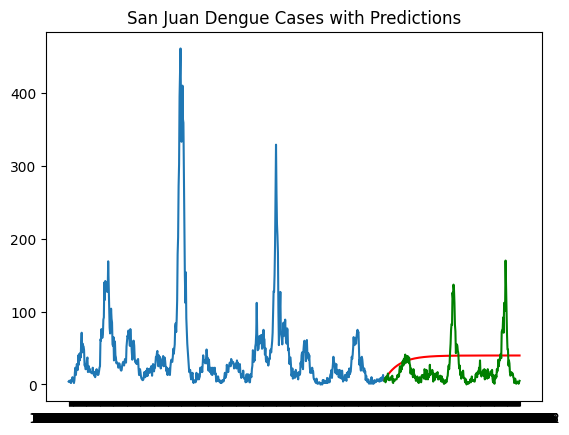

In [68]:
plt.plot(sj_df_train['total_cases'])
plt.plot(predictions, color='red') 
plt.plot(sj_df_test['total_cases'], color='green')
plt.title('San Juan Dengue Cases with Predictions')
plt.show()

predicted=6.158745, expected=5.000000
predicted=6.158745, expected=9.000000
predicted=10.025420, expected=3.000000
predicted=4.225407, expected=6.000000
predicted=7.125413, expected=11.000000
predicted=11.958757, expected=7.000000
predicted=8.092082, expected=7.000000
predicted=8.092082, expected=15.000000
predicted=15.825432, expected=9.000000
predicted=10.025420, expected=6.000000
predicted=7.125413, expected=6.000000
predicted=7.125413, expected=6.000000
predicted=7.125413, expected=7.000000
predicted=8.092082, expected=10.000000
predicted=10.992089, expected=8.000000
predicted=9.058751, expected=7.000000
predicted=8.092082, expected=12.000000
predicted=12.925426, expected=3.000000
predicted=4.225407, expected=2.000000
predicted=3.258738, expected=7.000000
predicted=8.092082, expected=5.000000
predicted=6.158745, expected=5.000000
predicted=6.158745, expected=7.000000
predicted=8.092082, expected=7.000000
predicted=8.092082, expected=7.000000
predicted=8.092082, expected=7.000000
pr

C:\Users\ron_d\AppData\Local\Temp\ipykernel_17968\1527890947.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = coef[0]
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17968\1527890947.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += coef[d+1] * lag[window-d-1]                 # I think this works w/o indenting the next lines into the 2nd for: if you have lag 2, you want the coeff(@lag_number) * train_sj value associated with that lag
C:\Users\ron_d\AppData\Local\Temp\ipykernel_17968\1527890947.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error i

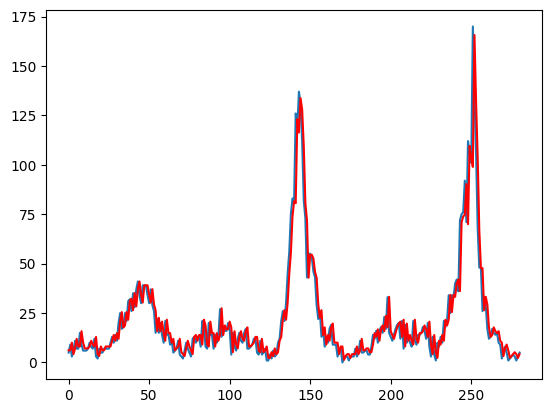

In [69]:
# massage my dataset into the format required below

#train_sj = sj_df_train['total_cases'].values
train_sj = sj_df_train['total_cases'].values.reshape(-1, 1)
#print(train_sj)

#test_sj = sj_df_test['total_cases'].values
test_sj = sj_df_test['total_cases'].values.reshape(-1, 1)

# train autoregression
# I have this done up top, and coef was already defined there for the walk-forward below

window = 1 # the "run-up" required for your model to produce a prediction per the number of lags used for your AR model, per the autocorrelation findings.  I used 1 lag.
##model = AutoReg(train, lags=1)
##model_fit = model.fit()
##coef = model_fit.params

# walk forward over time steps in test

history = train_sj[len(train_sj)-window:]                   # Subtracts lag (window) from the length of the training set. For example's sake, say len(train) = 700
#print(history)                                             # history ends up being 699 long if your lag is 1 as it is in this case
history = [history[i] for i in range(len(history))]         # Produces a list of arrays: total_cases in train_sj, 0 to 698 (range being endpt exclusive), still 699 long
predictions = list()                                        # initialize an empty predictions list
for t in range(len(test_sj)):                               # for t 0 to the end of the span of the test set...
    length = len(history)                                   # a list of arrays 699 long as seen earlier
    lag = [history[i] for i in range(length-window,length)] # range(699-1, 699), so 698 to 699: i.e. one lag as set in window earlier. Fetches the train_sj values associated with those indices
    yhat = coef[0]
    for d in range(window):                                 # in our case: for 0 to 1, 1 being excluded by range
        yhat += coef[d+1] * lag[window-d-1]                 # I think this works w/o indenting the next lines into the 2nd for: if you have lag 2, you want the coeff(@lag_number) * train_sj value associated with that lag
    obs = test_sj[t]                                        # (see how AutoReg produces coefficients at lags > 1 for verification of alignment)
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test_sj, predictions))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(test_sj, predictions)
print('Test MAE: %.3f' % mae)
# plot
plt.plot(test_sj)
plt.plot(predictions, color='red')
plt.show()


# !  
What I haven't processed yet, is how I'm getting this forecast in the cells above using .predict on the AR model, with a poor prediction, but when I do this walk-forward directly above, you get something much better.  What's AutoReg doing when you say .predict() then?

In [70]:
history

[array([5], dtype=int64),
 array([5], dtype=int64),
 array([9], dtype=int64),
 array([3], dtype=int64),
 array([6], dtype=int64),
 array([11], dtype=int64),
 array([7], dtype=int64),
 array([7], dtype=int64),
 array([15], dtype=int64),
 array([9], dtype=int64),
 array([6], dtype=int64),
 array([6], dtype=int64),
 array([6], dtype=int64),
 array([7], dtype=int64),
 array([10], dtype=int64),
 array([8], dtype=int64),
 array([7], dtype=int64),
 array([12], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=int64),
 array([7], dtype=int64),
 array([5], dtype=int64),
 array([5], dtype=int64),
 array([7], dtype=int64),
 array([7], dtype=int64),
 array([7], dtype=int64),
 array([7], dtype=int64),
 array([10], dtype=int64),
 array([13], dtype=int64),
 array([10], dtype=int64),
 array([14], dtype=int64),
 array([11], dtype=int64),
 array([20], dtype=int64),
 array([25], dtype=int64),
 array([17], dtype=int64),
 array([18], dtype=int64),
 array([25], dtype=int64),
 array([21], dtype=int64

In [71]:
history[0]

array([5], dtype=int64)

In [72]:
len(history)

282

# !  
Time permitting, this will be repeated for Iquitos.

__________________________________________________
This is how Brownlee produces a 7 day forecast using AutoReg.   See how it differs from the code that follows.

In [73]:
# # This is a tidy summary of what you need to do to produce ONE forecast however many time periods out (equal to your test set length)
# # This is all done above, but in separate cells with a few comments and checks in between.  Having it all in one spot can be useful when you just want to glance at the whole
# # process quickly.

# # It is taken directly from the Machine Learning Mastery site, and the below hasn't been edited to reflect my set-up.  It's only here for reference.

# # create and evaluate a static autoregressive model  

# from pandas import read_csv
# from matplotlib import pyplot
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # load dataset
# series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# # split dataset
# X = series.values  # Check the format on this.  I may need to use reshape to get my values arrayed like he has them (multiple rows)
# train, test = X[1:len(X)-7], X[len(X)-7:]

# # train autoregression
# model = AutoReg(train, lags=29)
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)

# # make predictions
# predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
# rmse = sqrt(mean_squared_error(test, predictions))

# print('Test RMSE: %.3f' % rmse)

# # plot results
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

______________________________
The code directly below is taken from https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

(He trained a model with a lag=29)

"The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

yhat = b0 + b1*X1 + b2*X2 ... bn*Xn"

In [74]:
# train autoregression

#window = 1 # the "run-up" required for your model to produce a prediction per the number of lags used for your AR model, per the autocorrelation findings.  I used 1 lag.
##model = AutoReg(train, lags=1)
##model_fit = model.fit()
##coef = model_fit.params

# walk forward over time steps in test

#history = train[len(train)-window:]
#history = [history[i] for i in range(len(history))]
#predictions = list()
#for t in range(len(test)):
# length = len(history)
# lag = [history[i] for i in range(length-window,length)]
# yhat = coef[0]
# for d in range(window):
# yhat += coef[d+1] * lag[window-d-1]
# obs = test[t]
# predictions.append(yhat)
# history.append(obs)
# print('predicted=%f, expected=%f' % (yhat, obs))